## Implementación de soluciones numéricas a ecuaciones diferenciales  parciales (parabólicas) con CUDA.

>Aprovecharemos las ecuaciones de Difusión (2D) y de Schrodinger (3D) para ejemplificar el uso de distintas herrmientas de CUDA para su solución numérica. De paso veremos también el uso de algunas librerias para FFT y visualización (OpenGL).

Pensemos en problemas del tipo:

$$\frac{\partial \phi(\vec{r},t)}{\partial t}  =  \mathbb{L} \left(t,\phi,\partial_{ii}\phi,\partial_{i}\phi \right)_{i=x,y,z}$$

El primer problema será escoger un esquema de discretización adecuado para el problema, en general podemos proponer de entrada una esquema explicito RK4 en la parte temporal y simplemente usar diferencias finitas para las derivadas espaciales.

### Runge-Kutta  4to orden (RK4)


$$ \dot{\phi}(t,\vec{r})  =   \mathbb{L}(t,\phi, ..)$$


si $\phi^n = \phi(t_n,\vec{r})$ con $t_n = n\delta t$

Recurrencia: $$\phi^{n+1} = \phi^n + \frac{1}{6}\delta t(k_1+2k_2+2k_3+k_4) \\$$
>$$k_1 = \mathbb{L}(t_n,\phi^n, ..) \\
  k_2 = \mathbb{L}(t_n+\frac{1}{2}\delta t, \phi^n+\frac{1}{2} k_1 \delta t, ..) \\
  k_3 = \mathbb{L}(t_n+\frac{1}{2}\delta t, \phi^n+\frac{1}{2} k_2 \delta t, ..)\\
  k_4 = \mathbb{L}(t_n+\delta t, \phi^n + k_3 \delta t, ..)$$
  
El error va como $O(\delta t^4)$

### Diferencias finitas

Si proponemos una discretización como $x_i = i \times h$ con $h = L / N$
$$\partial_x \phi(x_i,y_j,z_k) = \frac{\phi(x_{i+1},y_j,z_k)-\phi(x_{i-1},y_j,z_k)}{2 h} +O(h^2)$$
$$\partial_{xx} \phi(x_i,y_j,z_k) = \frac{\phi(x_{i+1},y_j,z_k)- 2\phi(x_{i},y_j,z_k) +\phi(x_{i-1},y_j,z_k)}{h^2} +O(h^2)$$

## Ecuacion de difusion (calor) (2D)

$$\frac{\partial T(\vec{r},t)}{\partial t}  =  D\nabla^2 T(\vec{r},t)$$

Con $D$ el coeficiente de difusión, si el coeficiente de difusion no es constante entonces tenemos.

$$\frac{\partial T(\vec{r},t)}{\partial t}  =  \nabla \cdot \left( D(\vec{r},t) \nabla T(\vec{r},t)\right)$$
$$\frac{\partial T(\vec{r},t)}{\partial t}  =  \nabla D(\vec{r},t) \cdot \nabla T(\vec{r},t) + D(\vec{r},t)\nabla^2 T(\vec{r},t) $$
mas la condicion inicial $T(\vec{r},t_0), D(\vec{r},t_0)$ asi como las condiciones de contorno

Utilizando la discretizacion previa, impone criterios de estabilidad para el esquema:
$$ \delta t < \frac{dl^2}{\sqrt{2} \times dim \times D}$$
para el caso de coeficiente de difusion contante$^1$.
>¿Para el caso no homogeneo bastaria con estimar el maximo de $D(\vec{r},t)$?

>Empecemos por definir el espacio para la solución y usar una caja cuadrada por simplicidad, de longitud L y con una discretización de N puntos

> Definamos una clase que se llame **solveHeat** en la cual implementaremos distintos metodos, como primer ejercision hagamos el caso CPU con la libreria de **Numpy**. 

En especifico resolveremos el problema de 4 fronteras a temperatura fija (T=0)  condicion inicial arbitraria

## El codigo

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
class solveHeat:
    ''' This class is for include distinct methods to solve 2D difussion equation and several implementations'''
    def __init__(self, nPointsX = 512, nPointsY=512, boxSize=[10,10], precision = 'single' ):
       # Parameters
        self.nPX = nPointsX
        self.nPY = nPointsY
        self.Lx = boxSize[0]
        self.Ly = boxSize[1]
        self.precision = precision
        if precision == 'single':
            from numpy import float32
            self.prec = float32
            self.strC = 'float'
        elif precision == 'double':
            from numpy import float64
            self.prec = float64
            self.strC = 'double'
        from numpy import int32
        self.intPrec = int32
        # Domain
        from numpy import linspace,ones,zeros_like,sqrt,exp,meshgrid,copy,max,min,zeros
        from time import time
        self.time = time
        self.cpy = copy
        self.max = max
        self.min = min
        self.x0 = -self.Lx/2.0
        self.y0 = -self.Ly/2.0
        xPoints = linspace(self.x0, self.Lx/2.0, self.nPX)
        yPoints = linspace(self.y0, self.Ly/2.0, self.nPY)
        X,Y = meshgrid(xPoints,yPoints)
        gaussian = 2.0*exp(-X**2/0.5-Y**2/0.5)
        #Solution
        self.diffusionC = self.prec(0.5)
        self.diffusionForm = '{myPrec} d = 0.1*sin(x);'.format(myPrec=self.strC)
        self.dx = xPoints[1]-xPoints[0]
        self.dy = yPoints[1]-yPoints[0]
        self.phiSol = zeros((self.nPX,self.nPY),dtype=self.prec)*self.prec(0.5) +gaussian.astype(self.prec) # Initial condition
        self.maxPhi = max(max(self.phiSol))
        self.minPhi = min(min(self.phiSol))
        self.phiK1 = self.cpy(self.phiSol)
        self.phiK2 = self.cpy(self.phiSol)
        self.phiSolNew = self.cpy(self.phiSol)
        # Stability
        self.dt = (self.dx*self.dx)/(sqrt(2)*2*self.diffusionC) *0.9
        self.setBoundaryC_CPU()
        # Performance
        self.timeCPU = []
        self.timeGlobal = []
        self.timeShared = []
        self.timeTex = []
        self.timing = True
        self.iterCPU = 0
        self.iterGPU = 0
        
    def setBoundaryC_CPU(self):
        self.phiSol[0,:] = self.prec(0)#self.prec(1)
        self.phiSol[-1,:] = self.prec(0)#self.prec(1)
        self.phiSol[:,0] = self.prec(0)#self.prec(-1)
        self.phiSol[:,-1] = self.prec(0)#self.prec(-1)
        #self.phiSol[:,0] = self.phiSol[:,-1]
    
    def rk4_CPU(self):
        if self.timing:
            t = self.time()
        self.phiK1 = self.cpy(self.phiSol)
        self.applyL(1)
        self.phiK1 = self.phiSol + self.prec(0.5)*self.dt* self.phiK2
        self.applyL(2)
        self.phiK1 = self.phiSol + self.prec(0.5)*self.dt* self.phiK2
        self.applyL(2)
        self.phiK1 = self.phiSol + self.dt*self.phiK2
        self.applyL(1)
        self.phiSol =  self.cpy(self.phiSolNew)
        self.setBoundaryC_CPU()
        if self.timing:
            self.timeCPU.append(self.time()-t)
        self.iterCPU += 1
    def applyL(self,coef):
        #Calculate lapacian and Ki
        invX = self.prec(1./self.dx)
        invY = self.prec(1./self.dy)
        self.phiK2[1:-1,1:-1] = (self.phiK1[2:,1:-1]-self.prec(2.0)*self.phiK1[1:-1,1:-1]+self.phiK1[:-2,1:-1])*invX*invX
        self.phiK2[1:-1,1:-1] += (self.phiK1[1:-1,2:]-self.prec(2.0)*self.phiK1[1:-1,1:-1]+self.phiK1[1:-1,:-2])*invY*invY
        self.phiK2[1:-1,1:-1]*= self.diffusionC
        self.phiSolNew +=  self.prec(coef)*self.dt*self.prec(1./6.)* self.phiK2
        #imshow(aux1,vmax=self.maxPhi,vmin=self.minPhi)
        
    def draw(self, n = 0):
        #self.maxPhi = self.max(self.max(self.phiSol))
        #self.minPhi = self.min(self.min(self.phiSol))
        fig = figure(n,figsize(5,5),dpi=200)
        im = imshow(self.phiSol,vmax=self.maxPhi,vmin=self.minPhi)
        colorbar(im)
    #################################################################
    ##################### C U D A     S T U F F ##########################
    #################################################################
    def _setDevice(self,ndev = None):
        ''' To use CUDA or OpenCL you need a context and a device to stablish the context o communication '''
        import pycuda.autoinit
        import pycuda.driver as cuda
        
        nDevices = cuda.Device.count()
        print "Available Devices:"
        for i in range(nDevices):
            dev = cuda.Device( i )
            print "  Device {0}: {1}".format( i, dev.name() )
        devNumber = 0
        if nDevices > 1:
            if ndev == None:
                devNumber = int(raw_input("Select device number: ")) 
            else:
                devNumber = ndev
        dev = cuda.Device( devNumber)
        cuda.Context.pop()  #Disable previus CUDA context
        ctxCUDA = dev.make_context()
        print "Using device {0}: {1}".format( devNumber, dev.name() ) 
        self.ctxCUDA = ctxCUDA
        self.dev = dev
        if self.timing:
            self.start = cuda.Event()
            self.end = cuda.Event()
        
    def initCUDA(self, method = 'global', nDev = None):
        ''' CUDA init. method can be = texture,global,shared  '''
        from pycuda import gpuarray
        from pycuda.compiler import SourceModule
        # Init Device
        if nDev == None:
            self._setDevice()
        else:
            self._setDevice(ndev = nDev)
        # Init data
        if method == 'global':
            self.phiSol_GPU          = gpuarray.to_gpu(self.phiSol)
            self.phiSolNew_GPU  = gpuarray.to_gpu(self.phiSol)
            self.phiK1_GPU          = gpuarray.to_gpu(self.phiSol)
            self.phiK2_GPU           = gpuarray.to_gpu(self.phiSol)
        # KERNELS
        self._auxElementwise()
        #self.cuBlock = (32,32,1)
        self.cuBlock = (16,16,1)
        self.cuGrid   = (self.nPX/self.cuBlock[0],self.nPY/self.cuBlock[1],1)
        cudaCode = open("CUDAkernels.cu","r")
        myCUDACode = cudaCode.read()
        downVar = ['blockDim.x','blockDim.y','blockDim.z','gridDim.x','gridDim.y','gridDim.z']
        upVar      = [str(self.cuBlock[0]),str(self.cuBlock[1]),str(self.cuBlock[2]),str(self.cuGrid[0]),str(self.cuGrid[1]),str(self.cuGrid[2])]
        dicVar = dict(zip(downVar,upVar))
        for i in downVar:
            myCUDACode = myCUDACode.replace(i,dicVar[i])
        if self.strC == 'double':
            myCUDACode = myCUDACode.replace('float','double')
        self.myCUDACode = myCUDACode
        myKernels = SourceModule(myCUDACode, options= [ '--ptxas-options=-v'])
        self.applyL_global = myKernels.get_function('globalRK4')
        self.applyL_shared = myKernels.get_function('sharedRK4')
        self.applyL_tex = myKernels.get_function('textureRK4')
        self.texturePhiSol = myKernels.get_texref('myTexture')
        self.surfacePhiSol = myKernels.get_surfref('mySurf')
        self.CUDAarrayK1 , cpy1 = self.np3DtoCudaArray(self.phiSol, allowSurfaceBind=True, testPrec = True, prec = 'single' )
        self.CUDAarrayK2 , cpy2 = self.np3DtoCudaArray(self.phiSol, allowSurfaceBind=True, testPrec = True, prec = 'single' )
    
        if self.strC == 'float':
            self.applyL_global.prepare('PPPfffff')
            self.applyL_shared.prepare('PPPffffff')
            self.applyL_tex.prepare('PPffffffi',texrefs=[self.texturePhiSol])
        else:
            self.applyL_global.prepare('PPPddddd')
            self.applyL_shared.prepare('PPPdddddd')
            self.applyL_tex.prepare('PPddddddi',texrefs=[self.texturePhiSol])
    
    def _auxElementwise(self):
        from pycuda.elementwise import ElementwiseKernel
        self.copyD2D = ElementwiseKernel(arguments = "{prec} *a, {prec} *b ".format(prec=self.strC),
                               operation = "a[i]=b[i]",
                               name = "copyD2D")
        self.calcKi = ElementwiseKernel(arguments = "{prec} *a, {prec} *b, {prec} *c, {prec} d ".format(prec=self.strC),
                               operation = "a[i]=b[i] + d*c[i]",
                               name = "calcKi")
    
    def rk4_GPU_global(self):
        if self.timing:
            self.start.record()
        self.copyD2D(self.phiK1_GPU,self.phiSol_GPU)
        #self.phiK1 = self.cpy(self.phiSol) 
        self.applyL_global.prepared_call(self.cuGrid,self.cuBlock,self.phiSolNew_GPU.gpudata, 
                                                              self.phiK1_GPU.gpudata, self.phiK2_GPU.gpudata, self.diffusionC, self.prec(1), self.dt, self.dx, self.dy)
        
        self.calcKi(self.phiK1_GPU,self.phiSol_GPU,self.phiK2_GPU, self.prec(0.5)*self.dt)
        #self.phiK1 = self.phiSol + self.prec(0.5)*self.dt* self.phiK2
        self.applyL_global.prepared_call(self.cuGrid, self.cuBlock, self.phiSolNew_GPU.gpudata, 
                                                              self.phiK1_GPU.gpudata, self.phiK2_GPU.gpudata, self.diffusionC, self.prec(2), self.dt, self.dx, self.dy)
        self.calcKi(self.phiK1_GPU,self.phiSol_GPU,self.phiK2_GPU, self.prec(0.5)*self.dt)
        #self.phiK1 = self.phiSol + self.prec(0.5)*self.dt* self.phiK2
        self.applyL_global.prepared_call(self.cuGrid,self.cuBlock,self.phiSolNew_GPU.gpudata, 
                                                              self.phiK1_GPU.gpudata, self.phiK2_GPU.gpudata, self.diffusionC, self.prec(2), self.dt, self.dx, self.dy)
        self.calcKi(self.phiK1_GPU,self.phiSol_GPU,self.phiK2_GPU, self.dt)
        #self.phiK1 = self.phiSol + self.dt*self.phiK2
        self.applyL_global.prepared_call(self.cuGrid,self.cuBlock,self.phiSolNew_GPU.gpudata, 
                                                              self.phiK1_GPU.gpudata, self.phiK2_GPU.gpudata, self.diffusionC, self.prec(1), self.dt, self.dx, self.dy)

        self.copyD2D(self.phiSol_GPU,self.phiSolNew_GPU)
        if self.timing:
            self.end.record()
            self.end.synchronize()
            self.timeGlobal.append(self.start.time_till(self.end)*1e-3)
        self.iterGPU += 1
        
    def rk4_GPU_shared(self):
        if self.timing:
            self.start.record()
        #self.copyD2D(self.phiK1_GPU,self.phiSol_GPU)
        #self.phiK1 = self.cpy(self.phiSol) 
        self.applyL_shared.prepared_call(self.cuGrid,self.cuBlock, self.phiSol_GPU.gpudata, self.phiSolNew_GPU.gpudata,  
                                         self.phiK2_GPU.gpudata, self.prec(0), self.prec(1), self.diffusionC, self.dt, self.dx, self.dy)
        #self.ctxCUDA.synchronize()
        #self.calcKi(self.phiK1_GPU,self.phiSol_GPU,self.phiK2_GPU, self.prec(0.5)*self.dt)
        #self.phiK1 = self.phiSol + self.prec(0.5)*self.dt* self.phiK2
        self.applyL_shared.prepared_call(self.cuGrid, self.cuBlock, self.phiSol_GPU.gpudata, self.phiSolNew_GPU.gpudata, 
                                                               self.phiK2_GPU.gpudata, self.prec(0.5), self.prec(2), self.diffusionC,self.dt, self.dx, self.dy)
        #self.calcKi(self.phiK1_GPU,self.phiSol_GPU,self.phiK2_GPU, self.prec(0.5)*self.dt)
        #self.phiK1 = self.phiSol + self.prec(0.5)*self.dt* self.phiK2
        self.applyL_shared.prepared_call(self.cuGrid,self.cuBlock, self.phiSol_GPU.gpudata,self.phiSolNew_GPU.gpudata, 
                                                               self.phiK2_GPU.gpudata, self.prec(0.5) , self.prec(2), self.diffusionC,self.dt, self.dx, self.dy)
        #self.calcKi(self.phiK1_GPU,self.phiSol_GPU,self.phiK2_GPU, self.dt)
        #self.phiK1 = self.phiSol + self.dt*self.phiK2
        self.applyL_shared.prepared_call(self.cuGrid,self.cuBlock, self.phiSol_GPU.gpudata,self.phiSolNew_GPU.gpudata, 
                                                               self.phiK2_GPU.gpudata, self.prec(1.0), self.prec(1), self.diffusionC,self.dt, self.dx, self.dy)

        self.copyD2D(self.phiSol_GPU,self.phiSolNew_GPU)
        if self.timing:
            self.end.record()
            self.end.synchronize()
            self.timeShared.append(self.start.time_till(self.end)*1e-3)
        self.iterGPU += 1
        #self.ctxCUDA.synchronize()
        #self.phiSol =  self.cpy(self.phiSolNew)
        
    def rk4_GPU_tex(self):
        if self.timing:
            self.start.record()
        #self.copyD2D(self.phiK1_GPU,self.phiSol_GPU)
        #self.phiK1 = self.cpy(self.phiSol)
        self.texturePhiSol.set_array(self.CUDAarrayK1)
        self.surfacePhiSol.set_array(self.CUDAarrayK2)
        self.applyL_tex.prepared_call(self.cuGrid,self.cuBlock, self.phiSol_GPU.gpudata, self.phiSolNew_GPU.gpudata,  
                                                         self.diffusionC, self.prec(1), self.prec(0),  self.dt, self.dx, self.dy,self.intPrec(0))
        #self.ctxCUDA.synchronize()
        #self.calcKi(self.phiK1_GPU,self.phiSol_GPU,self.phiK2_GPU, self.prec(0.5)*self.dt)
        #self.phiK1 = self.phiSol + self.prec(0.5)*self.dt* self.phiK2
        self.texturePhiSol.set_array(self.CUDAarrayK2)
        self.surfacePhiSol.set_array(self.CUDAarrayK1)
        self.applyL_tex.prepared_call(self.cuGrid,self.cuBlock, self.phiSol_GPU.gpudata, self.phiSolNew_GPU.gpudata,  
                                                         self.diffusionC, self.prec(2), self.prec(0.5),  self.dt, self.dx, self.dy,self.intPrec(0))
        #self.calcKi(self.phiK1_GPU,self.phiSol_GPU,self.phiK2_GPU, self.prec(0.5)*self.dt)
        #self.phiK1 = self.phiSol + self.prec(0.5)*self.dt* self.phiK2
        self.texturePhiSol.set_array(self.CUDAarrayK1)
        self.surfacePhiSol.set_array(self.CUDAarrayK2)
        self.applyL_tex.prepared_call(self.cuGrid,self.cuBlock, self.phiSol_GPU.gpudata, self.phiSolNew_GPU.gpudata,  
                                                         self.diffusionC, self.prec(2), self.prec(0.5),  self.dt, self.dx, self.dy,self.intPrec(0))
        #self.calcKi(self.phiK1_GPU,self.phiSol_GPU,self.phiK2_GPU, self.dt)
        #self.phiK1 = self.phiSol + self.dt*self.phiK2
        self.texturePhiSol.set_array(self.CUDAarrayK2)
        self.surfacePhiSol.set_array(self.CUDAarrayK1)
        self.applyL_tex.prepared_call(self.cuGrid,self.cuBlock, self.phiSol_GPU.gpudata, self.phiSolNew_GPU.gpudata,  
                                                          self.diffusionC, self.prec(1), self.prec(1.0),  self.dt, self.dx, self.dy,self.intPrec(1))
        #self.copyD2D(self.phiSol_GPU,self.phiSolNew_GPU)
        
        if self.timing:
            self.end.record()
            self.end.synchronize()
            self.timeTex.append(self.start.time_till(self.end)*1e-3)    
        self.iterGPU += 1
        
    def draw_GPU(self, n = 1):
        #self.maxPhi = self.max(self.max(self.phiSol))
        #self.minPhi = self.min(self.min(self.phiSol))
        fig = figure(n)
        im = imshow(self.phiSol_GPU.get(),vmax=self.maxPhi,vmin=self.minPhi)
        colorbar()
        
    def np3DtoCudaArray(self,npArray, allowSurfaceBind=False, testPrec = True,prec = 'single' ):
        import pycuda.driver as cuda
        dimension = len(npArray.shape)
        if dimension == 1:
            w = npArray.shape[0]
            h, d = 0,0
        if dimension == 2:
            w, h = npArray.shape[0], npArray.shape[1]
            d = 0
        if dimension == 3:
            w, h, d = npArray.shape
        descr3D = cuda.ArrayDescriptor3D()
        descr3D.width = w
        descr3D.height = h
        descr3D.depth = d
                
        if testPrec:
                    
            if self.precision == 'single':
              descr3D.format = cuda.dtype_to_array_format(npArray.dtype)
              descr3D.num_channels = 1
            else:
              descr3D.format = cuda.array_format.SIGNED_INT32
              descr3D.num_channels = 2
        else:
            descr3D.format = cuda.dtype_to_array_format(npArray.dtype)
            descr3D.num_channels = 1
  
        if allowSurfaceBind:
            descr3D.flags = cuda.array3d_flags.SURFACE_LDST
    
        cudaArray = cuda.Array(descr3D)
        if dimension == 3:
              copy3D = cuda.Memcpy3D()
              copy3D.set_src_host(npArray)
              copy3D.set_dst_array(cudaArray)
              copy3D.src_pitch = npArray.strides[0]
              copy3D.width_in_bytes = copy3D.src_pitch = npArray.strides[1]
              copy3D.src_height = copy3D.height = h
              copy3D.depth = d
              copy3D()
        if dimension == 2:
              copy3D = cuda.Memcpy2D()
              copy3D.set_src_host(npArray)
              copy3D.set_dst_array(cudaArray)
              copy3D.src_pitch = npArray.strides[0]
              copy3D.width_in_bytes = copy3D.src_pitch = npArray.strides[0]
              copy3D.src_height = copy3D.height = h
              copy3D(aligned=True)
        return cudaArray, copy3D
        
    def freeMemoryGPU(self):
        self.phiSol_GPU.gpudata.free()
        self.phiSolNew_GPU.gpudata.free()
        self.phiK1_GPU.gpudata.free()
        self.phiK2_GPU.gpudata.free()
        self.CUDAarrayK1.free()
        self.CUDAarrayK2.free()

### Calculando ...

Una vez con la clase lista, nos preocuoamos por jugar con las opciones que tenemos diponibles.

In [4]:
# Creamos un objeto con todos los metodos disponibles, automaticamente se inicializan los datos pero podemos modificarlos
# redefiniendo los parametros, variables o condiciones que nos interesen.
myS = solveHeat(nPointsX=128, nPointsY=128, boxSize=[5,5],precision='double')
print myS.dx,myS.dt

0.0393700787402 0.000986415932587


In [5]:
# Inicializamos el entorno con la GPU
myS.initCUDA()

Available Devices:
  Device 0: Tesla C2075
  Device 1: Quadro 2000
Select device number: 0
Using device 0: Tesla C2075


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:154: UserWarning: The CUDA compiler succeeded, but said the following:
ptxas info    : 0 bytes gmem, 296 bytes cmem[2]
ptxas info    : Compiling entry function 'sharedRK4' for 'sm_20'
ptxas info    : Function properties for sharedRK4
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 24 registers, 2048 bytes smem, 104 bytes cmem[0], 36 bytes cmem[16]
ptxas info    : Compiling entry function 'textureRK4' for 'sm_20'
ptxas info    : Function properties for textureRK4
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 21 registers, 100 bytes cmem[0], 36 bytes cmem[16]
ptxas info    : Compiling entry function 'globalRK4' for 'sm_20'
ptxas info    : Function properties for globalRK4
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 18 registers, 96 bytes cmem[0], 36 bytes cmem[16]



In [6]:
print myS.myCUDACode

#include <cuda_runtime.h>
#include <pycuda-complex.hpp>
#include <pycuda-helpers.hpp>
#include <surface_functions.h>
texture< fp_tex_double, cudaTextureType2D, cudaReadModeElementType> myTexture;
surface< void, 2> mySurf;

__global__ void globalRK4( double *phi_new, double *phiK1, double *phiK2, double diffusionC, double coef, double dt, double dx, double dy){

int tid_x = 16 * blockIdx.x + threadIdx.x;
int tid_y = 16 * blockIdx.y + threadIdx.y;
int tid   = 8 * 16 * tid_y + tid_x;
// Other indices
if (tid_x < 16*8-1 && tid_x > 0 ){
  
  if (tid_y < 16*8-1 && tid_y > 0 ){
    
    double laplax = 0.0;
    double laplay = 0.0;
    double idx = 1.0/dx;
    double idy = 1.0/dy;
    // k1_i+1,j
    int tid_aux = 8 * 16 * tid_y + tid_x + 1;
    laplax = phiK1[tid_aux]-2.0*phiK1[tid];
    // k1_i-1,j
    tid_aux = 8 * 16 * tid_y + tid_x - 1;
    laplax += phiK1[tid_aux];
    laplax *= idx*idx;
    // k1_i,j+1
    tid_aux = 8 * 16 * (tid_y+1) + tid_x;
    laplay = phiK1[tid_aux]-2.0*phiK1[tid]

(None, None)

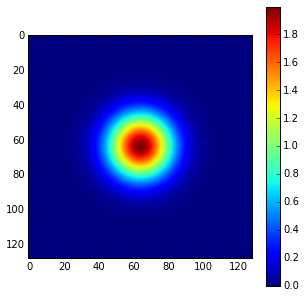

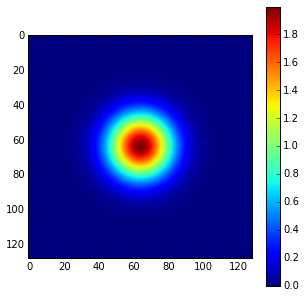

In [7]:
myS.draw(),myS.draw_GPU() # Estados iniciales

In [8]:
# Resolviendo con CPU y GPU
#myS.rk4_CPU()
#myS.rk4_GPU_global()
#myS.rk4_GPU_shared()
#myS.rk4_GPU_tex()

In [9]:
for i in range (1000):
    myS.rk4_GPU_global()
    #myS.rk4_GPU_shared()
    #myS.rk4_GPU_tex()
    myS.rk4_CPU()

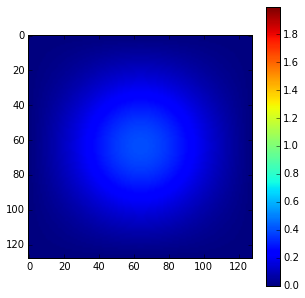

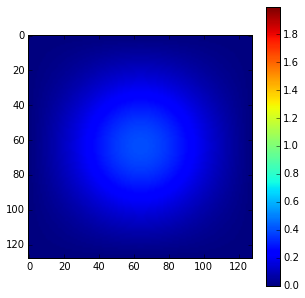

In [10]:
myS.draw_GPU() # Como se esperaba se enfria!
myS.draw()

In [11]:
sum(myS.timeCPU) # Tiempos de ejecucion

2.0341188907623291

In [12]:
sum(myS.timeTex) # Tiempos de ejecucion

0.0

In [13]:
sum(myS.timeGlobal)

6.5742886943072083

In [14]:
sum(myS.timeCPU)

2.0341188907623291

In [15]:
sum(myS.timeShared)

0.0

In [16]:
myS.iterCPU*myS.dt

0.98641593258709526

In [17]:
diff = abs(myS.phiSol-myS.phiSol_GPU.get())

In [18]:
np.max(diff),np.min(diff)

(3.639765357166258e-09, 0.0)

In [19]:
dir(myS.applyL_global)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattr__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_launch',
 '_launch_grid',
 '_launch_grid_async',
 '_launch_kernel',
 '_param_set_size',
 '_param_setf',
 '_param_seti',
 '_param_setv',
 '_set_block_shape',
 '_set_shared_size',
 'arg_format',
 'get_attribute',
 'param_set_texref',
 'prepare',
 'prepared_async_call',
 'prepared_call',
 'prepared_timed_call',
 'set_cache_config',
 'texrefs']

In [20]:
#myS.freeMemoryGPU()

In [21]:
from pycuda.tools import OccupancyRecord,DeviceData

In [22]:
devData = DeviceData(myS.dev)
myOcc = OccupancyRecord(devData,threads=256,shared_mem=0,registers=19)

In [23]:
32*32

1024

In [24]:
print myOcc.limited_by
print myOcc.occupancy
print myOcc.tb_per_mp
print myOcc.tb_per_mp_limits
print myOcc.warps_per_mp

regs
1.0
6
[(8, 'device'), (6, 'warps'), (6, 'regs')]
48


In [25]:
import pycuda.driver as cuda

In [26]:
cuda.get_version()

(5, 0, 0)

## Animación

In [27]:
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, codec='libx264')#, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

In [28]:
from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

### Version de CPU

In [29]:
from matplotlib import animation

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
#ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
#line, = ax.plot([], [], lw=2)
mySol = solveHeat(nPointsX=128, nPointsY=128, boxSize=[5,5],precision='double')
myDens = imshow(mySol.phiSol)
colorbar(myDens,shrink=0.79)
txt1 = plt.text(0,-3.5,' t = {0:.2f}'.format(0),verticalalignment= 'baseline')
txt2 = plt.text(70,-3.5,'Computing time {0:.4f} sec'.format(0.0000),verticalalignment= 'baseline')
# initialization function: plot the background of each frame
def init():
    #line.set_data([], [])
    mySol = solveHeat(nPointsX=128, nPointsY=128, boxSize=[5,5])
    return mySol,

# animation function.  This is called sequentially
def animate(i):
    for j in range(i):
        mySol.rk4_CPU()
    myDens.set_data(mySol.phiSol)
    txt1.set_text('t = {0:.2f}  n = {1}'.format(mySol.iterCPU*mySol.dt,mySol.iterCPU))
    txt2.set_text('Exec time CPU {0:.4f} sec'.format(sum(mySol.timeCPU)))
    return myDens

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=True)

# call our new function to display the animation
display_animation(anim)
# if you want to save the animation, uncomment this line
#anim.save('miAnimacion.mp4',fps=20,codec='libx264')

In [30]:
print mySol.iterCPU
del mySol

4950


In [31]:
from matplotlib import animation

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
#ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
#line, = ax.plot([], [], lw=2)
mySol = solveHeat(nPointsX=128, nPointsY=128, boxSize=[5,5],precision='double')
mySol.initCUDA(nDev=0)
myDens = imshow(mySol.phiSol_GPU.get())
colorbar(myDens,shrink=0.79)
txt1 = plt.text(0,-3.5,' t = {0:.2f}'.format(0),verticalalignment= 'baseline')
txt2 = plt.text(30,-3.5,'Exec time GPU (Global Mem) {0:.4f} sec'.format(0.0000),verticalalignment= 'baseline')
# initialization function: plot the background of each frame
def init():
    #line.set_data([], [])
    mySol = solveHeat(nPointsX=128, nPointsY=128, boxSize=[5,5])
    return mySol,

# animation function.  This is called sequentially
def animate(i):
    for j in range(i):
        mySol.rk4_GPU_global()
    myDens.set_data(mySol.phiSol_GPU.get())
    txt1.set_text('t = {0:.2f}'.format(mySol.iterGPU*mySol.dt))
    txt2.set_text('Exec time GPU (Global Mem) {0:.4f} sec'.format(sum(mySol.timeGlobal)))
    return myDens

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=True)

# call our new function to display the animation
display_animation(anim)
# if you want to save the animation, uncomment this line
#anim.save('miAnimacion.mp4',fps=20,codec='libx264')

Available Devices:
  Device 0: Tesla C2075
  Device 1: Quadro 2000
Using device 0: Tesla C2075


In [32]:
mySol.freeMemoryGPU()
del mySol

In [33]:
from matplotlib import animation

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
#ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
#line, = ax.plot([], [], lw=2)
mySol = solveHeat(nPointsX=128, nPointsY=128, boxSize=[5,5])
mySol.initCUDA()
myDens = imshow(mySol.phiSol_GPU.get())
colorbar(myDens,shrink=0.79)
txt1 = plt.text(0,-3.5,' t = {0:.2f}'.format(0),verticalalignment= 'baseline')
txt2 = plt.text(30,-3.5,'Exec time GPU (Shared Mem) sec'.format(0.0000),verticalalignment= 'baseline')
# initialization function: plot the background of each frame
def init():
    #line.set_data([], [])
    mySol = solveHeat(nPointsX=128, nPointsY=128, boxSize=[5,5])
    return mySol,

# animation function.  This is called sequentially
def animate(i):
    for j in range(i):
        mySol.rk4_GPU_shared()
    myDens.set_data(mySol.phiSol_GPU.get())
    txt1.set_text('t = {0:.2f}'.format(mySol.iterGPU*mySol.dt))
    txt2.set_text('Exec time GPU (Shared Mem) {0:.4f} sec'.format(sum(mySol.timeShared)))
    return myDens

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=True)

# call our new function to display the animation
display_animation(anim)
# if you want to save the animation, uncomment this line
#anim.save('miAnimacion.mp4',fps=20,codec='libx264')

Available Devices:
  Device 0: Tesla C2075
  Device 1: Quadro 2000
Select device number: 0
Using device 0: Tesla C2075


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:154: UserWarning: The CUDA compiler succeeded, but said the following:
ptxas info    : 0 bytes gmem, 296 bytes cmem[2]
ptxas info    : Compiling entry function 'sharedRK4' for 'sm_20'
ptxas info    : Function properties for sharedRK4
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 19 registers, 1024 bytes smem, 80 bytes cmem[0], 8 bytes cmem[16]
ptxas info    : Compiling entry function 'textureRK4' for 'sm_20'
ptxas info    : Function properties for textureRK4
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 22 registers, 76 bytes cmem[0], 8 bytes cmem[16]
ptxas info    : Compiling entry function 'globalRK4' for 'sm_20'
ptxas info    : Function properties for globalRK4
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 15 registers, 76 bytes cmem[0], 8 bytes cmem[16]



In [34]:
mySol.freeMemoryGPU()
del mySol

In [35]:
from matplotlib import animation

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
#ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
#line, = ax.plot([], [], lw=2)
mySol = solveHeat(nPointsX=128, nPointsY=128, boxSize=[5,5])
mySol.initCUDA()
myDens = imshow(mySol.phiSol_GPU.get())
colorbar(myDens,shrink=0.79)
txt1 = plt.text(0,-3.5,' t = {0:.2f}'.format(0),verticalalignment= 'baseline')
txt2 = plt.text(30,-3.5,'Exec time GPU (Tex-Surf Mem) sec'.format(0.0000),verticalalignment= 'baseline')
# initialization function: plot the background of each frame
def init():
    #line.set_data([], [])
    mySol = solveHeat(nPointsX=128, nPointsY=128, boxSize=[5,5])
    return mySol,

# animation function.  This is called sequentially
def animate(i):
    for j in range(i):
        mySol.rk4_GPU_tex()
    myDens.set_data(mySol.phiSol_GPU.get())
    txt1.set_text('t = {0:.2f}'.format(mySol.iterGPU*mySol.dt))
    txt2.set_text('Exec time GPU (Tex-Surf Mem) {0:.4f} sec'.format(sum(mySol.timeTex)))
    return myDens

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=True)

# call our new function to display the animation
display_animation(anim)
# if you want to save the animation, uncomment this line
#anim.save('miAnimacion.mp4',fps=20,codec='libx264')

Available Devices:
  Device 0: Tesla C2075
  Device 1: Quadro 2000
Select device number: 0
Using device 0: Tesla C2075


In [36]:
mySol.freeMemoryGPU()
del mySol

Code based on: 
>http://nbviewer.ipython.org/url/jakevdp.github.io/downloads/notebooks/AnimationEmbedding.ipynb

## Rendimiento

Ahora solo variemos en numero N de la malla cuadrada $N^2$ en la que resolvemos el problema .. Version corregida!

In [ ]:
nPoints = [128,256,512,1024,2048,4096,8192]

In [ ]:
meanVsSize_CPU    = []
meanVsSize_Global  = []
meanVsSize_Shared = []
meanVsSize_Tex      = []
meanVsSizeTotal_CPU    = []
meanVsSizeTotal_Global  = []
meanVsSizeTotal_Shared = []
meanVsSizeTotal_Tex      = []
for i in nPoints:
    solution = solveHeat(nPointsX=i, nPointsY=i, boxSize=[5,5])
    solution.initCUDA(nDev=0)
    nLoop = 1000
    for i in range(nLoop): solution.rk4_CPU()
    for i in range(nLoop): solution.rk4_GPU_global()
    meanVsSize_CPU.append(mean(solution.timeCPU))
    meanVsSize_Global.append(mean(solution.timeGlobal))
    meanVsSizeTotal_CPU.append(sum(solution.timeCPU))
    meanVsSizeTotal_Global.append(sum(solution.timeGlobal))
    solution.freeMemoryGPU()
    
    solution.__init__(nPointsX=i, nPointsY=i, boxSize=[5,5])
    solution.initCUDA(nDev=0)
    for i in range(nLoop): solution.rk4_GPU_shared()
    meanVsSize_Shared.append(mean(solution.timeShared))
    meanVsSizeTotal_Shared.append(sum(solution.timeShared))
    solution.freeMemoryGPU()
    
    solution.__init__(nPointsX=i, nPointsY=i, boxSize=[5,5])
    solution.initCUDA(nDev=0)
    for i in range(nLoop): solution.rk4_GPU_tex()
    meanVsSize_Tex.append(mean(solution.timeTex))
    meanVsSize_Tex.append(sum(solution.timeTex))
    solution.freeMemoryGPU()
    
    del solution

Available Devices:
  Device 0: Tesla C2075
  Device 1: Quadro 2000
Using device 0: Tesla C2075
Available Devices:
  Device 0: Tesla C2075
  Device 1: Quadro 2000
Using device 0: Tesla C2075
Available Devices:
  Device 0: Tesla C2075
  Device 1: Quadro 2000
Using device 0: Tesla C2075
Available Devices:
  Device 0: Tesla C2075
  Device 1: Quadro 2000
Using device 0: Tesla C2075
Available Devices:
  Device 0: Tesla C2075
  Device 1: Quadro 2000
Using device 0: Tesla C2075
Available Devices:
  Device 0: Tesla C2075
  Device 1: Quadro 2000
Using device 0: Tesla C2075
Available Devices:
  Device 0: Tesla C2075
  Device 1: Quadro 2000
Using device 0: Tesla C2075
Available Devices:
  Device 0: Tesla C2075
  Device 1: Quadro 2000
Using device 0: Tesla C2075
Available Devices:
  Device 0: Tesla C2075
  Device 1: Quadro 2000
Using device 0: Tesla C2075
Available Devices:

In [ ]:
plt.figure(1,figsize=(12,8),dpi=200)
plt.semilogx(nPoints,meanVsSize_CPU,'r-.*',label='CPU',linewidth=5.0,alpha=0.5)
plt.semilogx(nPoints,meanVsSize_Global,'b-*',label='Global',linewidth=3.0,alpha=0.9)
plt.semilogx(nPoints,meanVsSize_Sahred,'g-*',label='Shared',linewidth=3.0,alpha=0.5)
plt.semilogx(nPoints,meanVsSize_Tex,'b--o',label='Texture-Surf',linewidth=3.0,alpha=0.5)
plt.ylabel('Time (seg)')
plt.xlabel('Matrix Dimension')
#plt.xlim(xmin=250,xmax=2**13.1)
plt.legend(loc=2,labelspacing=0.5,fancybox=True, handlelength=3.5, borderaxespad=0.25, borderpad=0.25)
plt.xticks(nPoints, nPoints, rotation='vertical')

In [ ]:
plt.figure(1,figsize=(12,8),dpi=200)
#plt.semilogx(nPoints,meanVsSize_CPU,'r-.*',label='CPU',linewidth=5.0,alpha=0.5)
plt.semilogx(nPoints,meanVsSize_Global,'b-*',label='Global',linewidth=3.0,alpha=0.9)
plt.semilogx(nPoints,meanVsSize_Shared,'g-*',label='Shared',linewidth=3.0,alpha=0.5)
plt.semilogx(nPoints,meanVsSize_Tex,'b--o',label='Texture-Surf',linewidth=3.0,alpha=0.5)
plt.ylabel('Time (seg)')
plt.xlabel('N')
#plt.xlim(xmin=250,xmax=2**13.1)
plt.legend(loc=2,labelspacing=0.5,fancybox=True, handlelength=3.5, borderaxespad=0.25, borderpad=0.25)
plt.xticks(nPoints, nPoints, rotation='vertical')

In [ ]:
meanVsSize_CPU[-1]

In [ ]:
meanVsSize_Tex[-1]

In [ ]:
SpeedUPMaxDim = meanVsSize_CPU[-1]/meanVsSize_Tex[-1]
SpeedUPMaxDim

YEAAAHHHH!!!!!!!!!!!

> 

In [ ]:
%load CUDAkernels.cu

In [ ]:
#include <cuda_runtime.h>
#include <pycuda-complex.hpp>
#include <pycuda-helpers.hpp>
#include <surface_functions.h>
texture< fp_tex_float, cudaTextureType2D, cudaReadModeElementType> myTexture;
surface< void, 2> mySurf;

__global__ void globalRK4( float *phi_new, float *phiK1, float *phiK2, float diffusionC, float coef, float dt, float dx, float dy){

int tid_x = blockDim.x * blockIdx.x + threadIdx.x;
int tid_y = blockDim.y * blockIdx.y + threadIdx.y;
int tid   = gridDim.x * blockDim.x * tid_y + tid_x;
// Other indices
if (tid_x < blockDim.x*gridDim.x-1 && tid_x > 0 ){
  
  if (tid_y < blockDim.y*gridDim.y-1 && tid_y > 0 ){
    
    float laplax = 0.0;
    float laplay = 0.0;
    float idx = 1.0/dx;
    float idy = 1.0/dy;
    // k1_i+1,j
    int tid_aux = gridDim.x * blockDim.x * tid_y + tid_x + 1;
    laplax = phiK1[tid_aux]-2.0f*phiK1[tid];
    // k1_i-1,j
    tid_aux = gridDim.x * blockDim.x * tid_y + tid_x - 1;
    laplax += phiK1[tid_aux];
    laplax *= idx*idx;
    // k1_i,j+1
    tid_aux = gridDim.x * blockDim.x * (tid_y+1) + tid_x;
    laplay = phiK1[tid_aux]-2.0f*phiK1[tid];
    // k1_i,j-1
    tid_aux = gridDim.x * blockDim.x * (tid_y-1) + tid_x;
    laplay += phiK1[tid_aux];
    laplay *= idy*idy;
    
    phiK2[tid] = (laplax+laplay)*diffusionC;
    phi_new[tid] += (laplax+laplay)*coef*dt*(1.0f/6.0f)*diffusionC;
    
    
  }
  
}
//else return;

}

__global__ void sharedRK4(float *phi, float *phi_new, float *phiK2, float coefIter, float coef, float diffusionC, float dt, float dx, float dy){
  
  int tid_x = blockDim.x * blockIdx.x + threadIdx.x;
  int tid_y = blockDim.y * blockIdx.y + threadIdx.y;
  int tid   = gridDim.x * blockDim.x * tid_y + tid_x;
  // State
  float state, stateK2;
  state = phi[tid];
  stateK2 = phiK2[tid];
  // Shared
  __shared__ float k1_sh[ blockDim.x ][ blockDim.y ];
  __syncthreads();
  k1_sh[ threadIdx.x ][ threadIdx.y ] = state + coefIter*dt*stateK2;
  __syncthreads();
  
  // Calculate Laplacian
  if (tid_x < blockDim.x*gridDim.x-1 && tid_x > 0 ){
    if (tid_y < blockDim.y*gridDim.y-1 && tid_y > 0 ){
      
      float lapla=0.0;
      float idx = 1.0/dx;
      float idy = 1.0/dy;
      
      if (threadIdx.x<blockDim.x-1 && threadIdx.x>0){
	  lapla = k1_sh[threadIdx.x+1][ threadIdx.y ]+k1_sh[threadIdx.x-1][ threadIdx.y ] - 2.0*k1_sh[threadIdx.x][ threadIdx.y ];
	  }
      else if (threadIdx.x == blockDim.x-1) lapla = (phi[tid+1]+ coefIter*dt*phiK2[tid+1]) +k1_sh[threadIdx.x-1][ threadIdx.y ] - 2.0*k1_sh[threadIdx.x][ threadIdx.y ];
      else if (threadIdx.x == 0)            lapla = k1_sh[threadIdx.x+1][ threadIdx.y ]+ (phi[tid-1]+ coefIter*dt*phiK2[tid-1]) - 2.0*k1_sh[threadIdx.x][ threadIdx.y ];
      lapla *= idx*idx;
      
      if (threadIdx.y<blockDim.y-1 && threadIdx.y>0){
	  lapla += (k1_sh[threadIdx.x][ threadIdx.y+1 ]+k1_sh[threadIdx.x][ threadIdx.y-1 ]- 2.0*k1_sh[threadIdx.x][ threadIdx.y ])*idy*idy;}
      else if (threadIdx.y == blockDim.y-1) lapla += ((phi[gridDim.y * blockDim.y * (tid_y+1) + tid_x]+ coefIter*dt*phiK2[gridDim.x * blockDim.x * (tid_y+1) + tid_x])+k1_sh[threadIdx.x][ threadIdx.y-1 ]- 2.0*k1_sh[threadIdx.x][ threadIdx.y ])*idy*idy;
      else if (threadIdx.y == 0)            lapla += (k1_sh[threadIdx.x][ threadIdx.y+1 ] + (phi[gridDim.x * blockDim.x * (tid_y-1) + tid_x]+ coefIter*dt*phiK2[gridDim.x * blockDim.x * (tid_y-1) + tid_x])- 2.0*k1_sh[threadIdx.x][ threadIdx.y ])*idy*idy;

      lapla *= diffusionC;
      phiK2[tid] = lapla;
      phi_new[tid] += coef*dt*(1.0f/6.0f)*lapla;
    }}
  
  
}

__global__ void textureRK4(float *phi, float *phi_new, float diffusionC, float coef, float coefIter, float dt, float dx, float dy, int lastStep){
  
  int tid_x = blockDim.x * blockIdx.x + threadIdx.x;
  int tid_y = blockDim.y * blockIdx.y + threadIdx.y;
  int tid   = gridDim.x * blockDim.x * tid_y + tid_x;
  float center, left, right;
  float up, down;
  center = fp_tex2D(myTexture, (float)tid_x,   (float)tid_y);
  left   = fp_tex2D(myTexture, (float)tid_x-1, (float)tid_y);
  right  = fp_tex2D(myTexture, (float)tid_x+1, (float)tid_y);
  up     = fp_tex2D(myTexture, (float)tid_x,   (float)tid_y+1);
  down   = fp_tex2D(myTexture, (float)tid_x,   (float)tid_y-1);
  
  float lapla=0.0;
  float idx=1.0/dx;
  float idy=1.0/dy;
  lapla = (left+right-2.0*center)*idx*idx+(up+down-2.0*center)*idy*idy;
  lapla *= diffusionC;
  
  // Boundary
  if (tid_x == blockDim.x*gridDim.x-1 or tid_x == 0 or tid_y == blockDim.y*gridDim.y-1 or tid_y == 0) lapla = 0.0;
  float phi_o = phi[tid];
  float k1_next = phi_o + coefIter*dt*lapla;
  surf2Dwrite( k1_next , mySurf, tid_x*sizeof(float), tid_y,  cudaBoundaryModeClamp);
  
  phi_new[tid] += coef*dt*(1.0f/6.0f)*lapla;
  
  if (lastStep == 1){
    phi[tid] = phi_new[tid];
    surf2Dwrite( phi_o , mySurf, tid_x*sizeof(float), tid_y,  cudaBoundaryModeClamp);
  }
  
}

### Referencias

1. http://www.sciencedirect.com/science/article/pii/S0168927413000627